In [11]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import planetary_computer
from pystac_client import Client
from shapely.geometry import Polygon, box
import rioxarray as rio
import pystac
from IPython.display import Image
%matplotlib inline

# Sources

This notebook is a combination of Emma Marshall's [Microsoft Planetary Computer Sentinel-1 RTC Imagery Data cleaning and organization tutorial](https://e-marshall.github.io/sentinel1_rtc/nbs/PC_RTC.html) and Deepak Cherian's Flox [tutorial](https://xarray.dev/blog/flox).

# Data Catalog

We will use the [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/) [STAC](https://stacspec.org/en) catalog to get the imagery we need for our study.F Specifically, we will interface with Microsofts planetary computer STAC catalog using `pystac_client`'s `Client`

Please check out the `STAC` link above to learn more about what a `STAC` is

We will be using planetary computer's [Sentinel 1 Radiometrically Terrain Corrected (RTC)](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc) catalog which you need to register for (it is free) to receive an API token. This processing takes ~1 day to receive. This is onyl something you need to do once. You can request access [here](https://planetarycomputer.microsoft.com/account/request).

In [12]:
catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
catalog

<Client id=microsoft-pc>

## Get the lake locations

`surface_CW2019_rasterized_single_grid.tif` is a rasterized version of a 100 km$^2$ subset of melt lake locations from [Dunmire et al](https://tc.copernicus.org/articles/15/2983/2021/) and the data repo [here](https://zenodo.org/records/4813833). Specifically the surface_CW2019 file in the lakes.zip. I needed to rasterize the vector data in order to use it with flox. I also made a 50% larger buffer around the polygons before rasterizing to ensure we are closer to a maximum lake area.

In [13]:
lake_rasters = rio.open_rasterio(
    "./surface_CW2019_rasterized_single_grid.tif", chunks="auto"
).squeeze()

create a bounding box using shapely's `box` which we will use as our ROI for our catalog query

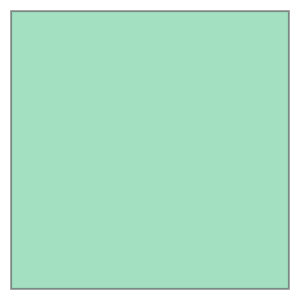

In [14]:
lake_rasters.rio.bounds()
bound_box_3413 = box(*lake_rasters.rio.bounds())
bound_box_3413                   

Reproject to 4326

In [15]:
gdf_box = gpd.GeoDataFrame(geometry=[bound_box_3413],crs=3413)
gdf_box_4326 = gdf_box.to_crs(4326)
gdf_box_4326.geometry[0].bounds

(-50.928903512005206, 68.35764741284956, -48.26666489492795, 69.31899293113067)

Now set your time range (this can be for as long as you want depending on your computational resources available). Since we want Sentinel-1 data, we will use the `sentinel-1-rtc` collection

In [16]:
time_range = '2019-01-01/2019-12-31'

search = catalog.search(collections=["sentinel-1-rtc"], intersects=gdf_box_4326.geometry[0], datetime=time_range)
items = search.get_all_items()
len(items)

/home/laserglaciers/anaconda3/envs/cu_xarray/lib/python3.11/site-packages/pystac_client/item_search.py:849: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


369

Convert to a geodataframe

In [17]:
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs='epsg:4326')
df.head(5)

,geometry,datetime,platform,s1:shape,proj:bbox,proj:epsg,proj:shape,end_datetime,constellation,s1:resolution,...,sar:center_frequency,sar:resolution_range,s1:product_timeliness,sar:resolution_azimuth,sar:pixel_spacing_range,sar:observation_direction,sar:pixel_spacing_azimuth,sar:looks_equivalent_number,s1:instrument_configuration_ID,sat:platform_international_designator
0,"POLYGON ((-43.00074 67.11738, -43.20604 66.812...",2019-12-31T09:35:40.725167Z,SENTINEL-1B,"[28945, 22116]","[333220.0, 7410130.0, 622670.0, 7631290.0]",32623,"[22116, 28945]",2019-12-31 09:35:53.224006+00:00,Sentinel-1,high,...,5.405,20,Fast-24h,22,10,right,10,4.4,1,2016-025A
1,"POLYGON ((-46.69624 67.69775, -46.84761 67.483...",2019-12-29T09:51:56.813271Z,SENTINEL-1B,"[28519, 21386]","[430750.0, 7489880.0, 715940.0, 7703740.0]",32622,"[21386, 28519]",2019-12-29 09:52:09.312158+00:00,Sentinel-1,high,...,5.405,20,NRT-3h,22,10,right,10,4.4,1,2016-025A
2,"POLYGON ((-45.21478 69.66482, -45.78214 68.947...",2019-12-29T09:51:29.797754Z,SENTINEL-1B,"[30168, 25979]","[227790.0, 7646700.0, 529470.0, 7906490.0]",32623,"[25979, 30168]",2019-12-29 09:51:44.312877+00:00,Sentinel-1,high,...,5.405,20,Fast-24h,22,10,right,10,4.4,1,2016-025A
3,"POLYGON ((-48.99237 67.32090, -49.17071 67.041...",2019-12-28T10:00:59.852102Z,SENTINEL-1A,"[28461, 22054]","[334920.0, 7436630.0, 619530.0, 7657170.0]",32622,"[22054, 28461]",2019-12-28 10:01:12.351341+00:00,Sentinel-1,high,...,5.405,20,Fast-24h,22,10,right,10,4.4,6,2014-016A
4,"POLYGON ((-47.95501 68.77014, -48.14571 68.508...",2019-12-28T10:00:34.852123Z,SENTINEL-1A,"[28353, 21948]","[372250.0, 7601610.0, 655780.0, 7821090.0]",32622,"[21948, 28353]",2019-12-28 10:00:47.351362+00:00,Sentinel-1,high,...,5.405,20,Fast-24h,22,10,right,10,4.4,6,2014-016A


In [18]:
df.columns

Index(['geometry', 'datetime', 'platform', 's1:shape', 'proj:bbox',
       'proj:epsg', 'proj:shape', 'end_datetime', 'constellation',
       's1:resolution', 'proj:transform', 's1:datatake_id', 'start_datetime',
       's1:orbit_source', 's1:slice_number', 's1:total_slices',
       'sar:looks_range', 'sat:orbit_state', 'sar:product_type',
       'sar:looks_azimuth', 'sar:polarizations', 'sar:frequency_band',
       'sat:absolute_orbit', 'sat:relative_orbit', 's1:processing_level',
       'sar:instrument_mode', 'sar:center_frequency', 'sar:resolution_range',
       's1:product_timeliness', 'sar:resolution_azimuth',
       'sar:pixel_spacing_range', 'sar:observation_direction',
       'sar:pixel_spacing_azimuth', 'sar:looks_equivalent_number',
       's1:instrument_configuration_ID',
       'sat:platform_international_designator'],
      dtype='object')

In [19]:
Image(url=items[0].assets["rendered_preview"].href)

In [20]:
# table = rich.table.Table('key','value')
# for k,v in sorted(items[0].properties.items()):
#     table.add_row(k, str(v))
# table

## Set up Dask
Set up a local dask cluster. This can get complicated real fast and depends on your set up

Read more about it [here](https://discourse.pangeo.io/t/understanding-how-to-use-dask-local-cluster-with-xarray/969), and [here](https://docs.dask.org/en/stable/deploying.html), and [here](https://docs.dask.org/en/latest/scheduling.html)

In [21]:
from dask.distributed import LocalCluster
cluster = LocalCluster()          # Fully-featured local Dask cluster
client = cluster.get_client()
print(client.dashboard_link)

http://127.0.0.1:8787/status


Task exception was never retrieved
future: <Task finished name='Task-5499' coro=<Client._gather.<locals>.wait() done, defined at /home/laserglaciers/anaconda3/envs/cu_xarray/lib/python3.11/site-packages/distributed/client.py:2187> exception=AllExit()>
Traceback (most recent call last):
  File "/home/laserglaciers/anaconda3/envs/cu_xarray/lib/python3.11/site-packages/distributed/client.py", line 2196, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-5535' coro=<Client._gather.<locals>.wait() done, defined at /home/laserglaciers/anaconda3/envs/cu_xarray/lib/python3.11/site-packages/distributed/client.py:2187> exception=AllExit()>
Traceback (most recent call last):
  File "/home/laserglaciers/anaconda3/envs/cu_xarray/lib/python3.11/site-packages/distributed/client.py", line 2196, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-5472' coro=<C

# Make Datacube

We will use `stackstac.stack` to stack all of the images from `items` over time to create a datacube which we can use to grouby and sample our lakes! 

In [22]:
import stackstac
import os
bounds = gdf_box_4326.geometry[0].bounds
image_array = stackstac.stack(
    planetary_computer.sign(items), bounds_latlon=bounds, epsg=3413
) #xarray data array

/home/laserglaciers/anaconda3/envs/cu_xarray/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [23]:
image_array

<xarray.DataArray 'stackstac-ed93a77d2c707fc3ffc3b6e8a0d752d4' (time: 369,
                                                                band: 2,
                                                                y: 11562,
                                                                x: 11569)>
dask.array<fetch_raster_window, shape=(369, 2, 11562, 11569), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                   (time) datetime64[ns] 2019-01-02T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDH_2019...
  * band                                   (band) <U2 'hh' 'hv'
  * x                                      (x) float64 -2.45e+05 ... -1.29e+05
  * y                                      (y) float64 -2.252e+06 ... -2.368e+06
    sar:pixel_spacing_range                int64 10
    ...                                     ...
    sat:absolute_orbit                     (time) int64 25297 25297 ... 19607
    sar:resolution_range                   int64 20
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            (band) <U175 'Terrain-corrected ga...
    title                                  (band) <U43 'HH: horizontal transm...
    epsg                                   int64 3413
Attributes:
    spec:           RasterSpec(epsg=3413, bounds=(-244974.672432518, -2367761...
    crs:            epsg:3413
    transform:      | 10.02, 0.00,-244974.67|\n| 0.00,-10.02,-2251864.45|\n| ...
    resolution_xy:  (10.023923746164655, 10.023923743749037)

We can also just read a single image like this

In [24]:
stac_item = pystac.read_file(f'https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-1-rtc/items/{items[0].id}')

In [25]:
stac_item

<Item id=S1B_IW_GRDH_1SDH_20191231T093528_20191231T093553_019607_0250E4_rtc>

We need to convert from digitial numbers to decibls for this case using SAR imagery. A bit more can be read about it [here](https://forum.step.esa.int/t/db-or-dn-for-image-processing/4823/5). Also in the Benedek and Willis [here](https://tc.copernicus.org/articles/15/1587/2021/)

In [26]:
def power_to_db(input_arr):
    return (10*np.log10(np.abs(input_arr)))

Cache the individual bands into variables. For this purpose, I believe using the HV band is what we need (?) according to [Rignot et al](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2000GL012484) and is what [Benedek and Willis](https://tc.copernicus.org/articles/15/1587/2021/) used.
> "HV polariza- tion of C-band SAR can penetrate up to a few metres of ice"

In [27]:
da_hv = image_array.sel(band='hv')

In [28]:
da_hh = image_array.sel(band='hh')

## Align the image stack with the lake rasters

For flox, and generally, we need to make sure our lakes are aligned with the image stack. So first let's clip the image stack using rioxarray and make reproject to make sure everything is aligned and ready to be used by the group by.

In [29]:
image_array = image_array.rio.clip([bound_box_3413],image_array.rio.crs, drop=True,invert=False, all_touched=True) #not sure if this is right but we need to make them match somehow

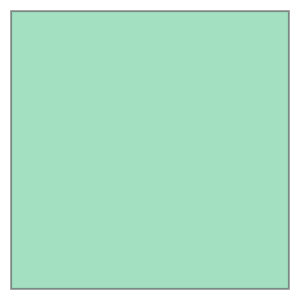

In [30]:
bound_box_3413 # The bounds we clipped to

Note the difference in x and y dims

In [31]:
image_array 

<xarray.DataArray 'stackstac-ed93a77d2c707fc3ffc3b6e8a0d752d4' (time: 369,
                                                                band: 2,
                                                                y: 9977, x: 9977)>
dask.array<getitem, shape=(369, 2, 9977, 9977), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/40)
  * time                                   (time) datetime64[ns] 2019-01-02T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDH_2019...
  * band                                   (band) <U2 'hh' 'hv'
  * x                                      (x) float64 -2.347e+05 ... -1.347e+05
  * y                                      (y) float64 -2.26e+06 ... -2.36e+06
    sar:pixel_spacing_range                int64 10
    ...                                     ...
    sar:resolution_range                   int64 20
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            (band) <U175 'Terrain-corrected ga...
    title                                  (band) <U43 'HH: horizontal transm...
    epsg                                   int64 3413
    spatial_ref                            int64 0
Attributes:
    spec:           RasterSpec(epsg=3413, bounds=(-244974.672432518, -2367761...
    resolution_xy:  (10.023923746164655, 10.023923743749037)

Now we need to make sure that the lake raster have the same shape as `image_array`. 

In [32]:
lake_rasters = lake_rasters.rio.reproject_match(image_array) #magic

In [33]:
lake_rasters

<xarray.DataArray (y: 9977, x: 9977)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0
  * x            (x) float64 -2.347e+05 -2.347e+05 ... -1.347e+05 -1.347e+05
  * y            (y) float64 -2.26e+06 -2.26e+06 ... -2.36e+06 -2.36e+06
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0.0

In [34]:
# # Remove any small floating point error in coordinate locations
_, lakes_aligned = xr.align(image_array, lake_rasters, join="override")
lakes_aligned

<xarray.DataArray (y: 9977, x: 9977)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0
  * x            (x) float64 -2.347e+05 -2.347e+05 ... -1.347e+05 -1.347e+05
  * y            (y) float64 -2.26e+06 -2.26e+06 ... -2.36e+06 -2.36e+06
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0.0

Get the number of lakes and the lake id's

In [35]:
lake_id = np.unique(lakes_aligned.data)
# 0 is used as NULL
lake_id = lake_id[lake_id != 0]
print(f"There are {len(lake_id)} lakes!")

There are 270 lakes!


In [36]:
lake_id

array([  1.,   2.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  42.,  43.,  44.,  45.,  47.,  48.,  49.,
        50.,  51.,  52.,  53.,  55.,  56.,  57.,  58.,  61.,  63.,  64.,
        65.,  66.,  67.,  68.,  70.,  71.,  74., 152., 153., 155., 158.,
       160., 166., 174., 178., 181., 182., 183., 184., 185., 188., 191.,
       192., 193., 196., 197., 199., 200., 202., 203., 205., 207., 209.,
       211., 215., 216., 217., 218., 219., 220., 222., 224., 225., 226.,
       231., 232., 233., 235., 236., 237., 239., 243., 245., 246., 247.,
       250., 253., 254., 255., 256., 257., 258., 261., 262., 263., 264.,
       267., 268., 270., 271., 274., 276., 279., 282., 285., 286., 289.,
       292., 293., 294., 296., 298., 299., 303., 304., 305., 310., 311.,
       312., 316., 317., 321., 322., 323., 324., 32

## Cache ascendign and descending paths and set chunk sizes 

Usign ascending and descending paths together can be an issue with different values. So for now let's just split them up and treat them separately. 
Setting a chunk size can also be very tricky and depends on lots your computer etc. A general rule of thumb is to have each chunk be around 100 mb to 1 gb. However, since I have a decent amount of memory available, I sent mine kind of large. Chunk sizes should be made with some knowledge of the data at hand. Since we are interested in time series, I used the entire time dimension. I also try to keep the chunks evenly divisible. 

In [37]:
da_asc = image_array.where(image_array['sat:orbit_state'] == 'ascending', drop=True)
da_desc = image_array.where(image_array['sat:orbit_state'] == 'descending', drop=True)
da_asc_hv = da_asc.sel(band='hv')
da_asc_hv = da_asc_hv.chunk({"time": 114, "x": 907, "y": 907})

In [38]:
da_asc_hv

<xarray.DataArray 'stackstac-ed93a77d2c707fc3ffc3b6e8a0d752d4' (time: 114,
                                                                y: 9977, x: 9977)>
dask.array<rechunk-merge, shape=(114, 9977, 9977), dtype=float64, chunksize=(114, 907, 907), chunktype=numpy.ndarray>
Coordinates: (12/40)
  * time                                   (time) datetime64[ns] 2019-01-06T2...
    id                                     (time) <U66 dask.array<chunksize=(114,), meta=np.ndarray>
    band                                   <U2 'hv'
  * x                                      (x) float64 -2.347e+05 ... -1.347e+05
  * y                                      (y) float64 -2.26e+06 ... -2.36e+06
    sar:pixel_spacing_range                int64 10
    ...                                     ...
    sar:resolution_range                   int64 20
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            <U175 'Terrain-corrected gamma nau...
    title                                  <U43 'HV: horizontal transmit, ver...
    epsg                                   int64 3413
    spatial_ref                            int64 0
Attributes:
    spec:           RasterSpec(epsg=3413, bounds=(-244974.672432518, -2367761...
    resolution_xy:  (10.023923746164655, 10.023923743749037)

In [39]:
import flox.xarray
da_asc_hv.attrs['spec'] = str(da_asc_hv.attrs['spec'])
da_asc_hv.attrs['spec']
da_asc_hv_sel = da_asc_hv.isel(time=slice(0,10))

Convert to db

In [40]:
da_asc_hv_sel = power_to_db(da_asc_hv_sel)

In [ ]:
lake_mean = flox.xarray.xarray_reduce(
    da_asc_hv_sel,
    lakes_aligned.rename("lake"),
    func="mean",
    expected_groups=(lake_id,),
)
lake_mean = lake_mean.compute()

In [ ]:
Cluster.shutdown() 